In [2]:
# NIFTY 50 LSTM Stock Price Prediction with Log Returns
# Part 1: Data Preparation, Model Training, and Evaluation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Configuration class for easy parameter management"""
    # Data parameters
    DATA_PATH = '/content/drive/MyDrive/LSTM/one_minute_final2.csv'  # Update with your file path
    DATE_COLUMN = 'date'
    FEATURE_COLUMNS = ['open', 'high', 'low', 'close']
    TARGET_COLUMN = 'close'

    # Model parameters
    LOOKBACK_PERIOD = 60  # Use 60 minutes of historical data
    TRAIN_SPLIT = 0.7
    VAL_SPLIT = 0.15
    TEST_SPLIT = 0.15

    # LSTM architecture
    LSTM_UNITS = [100, 50]  # Two LSTM layers
    DROPOUT_RATE = 0.2
    DENSE_UNITS = 25

    # Training parameters
    BATCH_SIZE = 64
    EPOCHS = 100
    LEARNING_RATE = 0.001
    PATIENCE = 15  # Early stopping patience

    # Model saving
    MODEL_SAVE_PATH = 'nifty50_lstm_model.keras'
    SCALER_SAVE_PATH = 'scaler.pkl'

config = Config()

# ============================================================================
# DATA LOADING AND EXPLORATION
# ============================================================================

def load_and_explore_data(file_path):
    """Load data and perform initial exploration"""
    print("="*80)
    print("LOADING AND EXPLORING DATA")
    print("="*80)

    # Load data
    df = pd.read_csv(file_path)

    # Convert date to datetime
    df[config.DATE_COLUMN] = pd.to_datetime(df[config.DATE_COLUMN])

    # Sort by date
    df = df.sort_values(config.DATE_COLUMN).reset_index(drop=True)

    print(f"\nDataset Shape: {df.shape}")
    print(f"\nFirst few rows:")
    print(df.head())
    print(f"\nLast few rows:")
    print(df.tail())
    print(f"\nData Types:")
    print(df.dtypes)
    print(f"\nMissing Values:")
    print(df.isnull().sum())
    print(f"\nBasic Statistics (Raw Prices):")
    print(df[config.FEATURE_COLUMNS].describe())

    return df

In [5]:
# ============================================================================
# DATA LOADING AND EXPLORATION
# ============================================================================

def load_and_explore_data(file_path):
    """Load data and perform initial exploration"""
    print("="*80)
    print("LOADING AND EXPLORING DATA")
    print("="*80)

    # Load data
    df = pd.read_csv(file_path)

    # Convert date to datetime
    df[config.DATE_COLUMN] = pd.to_datetime(df[config.DATE_COLUMN])

    # Sort by date
    df = df.sort_values(config.DATE_COLUMN).reset_index(drop=True)

    print(f"\nDataset Shape: {df.shape}")
    print(f"\nFirst few rows:")
    print(df.head())
    print(f"\nLast few rows:")
    print(df.tail())
    print(f"\nData Types:")
    print(df.dtypes)
    print(f"\nMissing Values:")
    print(df.isnull().sum())
    print(f"\nBasic Statistics (Raw Prices):")
    print(df[config.FEATURE_COLUMNS].describe())

    return df

In [6]:
# ============================================================================
# LOG RETURNS CALCULATION
# ============================================================================

def calculate_log_returns(df):
    """Calculate log returns from prices"""
    print("\n" + "="*80)
    print("CALCULATING LOG RETURNS")
    print("="*80)

    df_returns = df.copy()

    # Calculate log returns for each feature
    for col in config.FEATURE_COLUMNS:
        df_returns[f'{col}_log_return'] = np.log(df[col] / df[col].shift(1))

    # Drop the first row (NaN due to shift)
    df_returns = df_returns.dropna().reset_index(drop=True)

    # Store original prices for later conversion
    df_returns['original_close'] = df[col].iloc[1:].reset_index(drop=True)

    print(f"\nLog returns calculated for: {config.FEATURE_COLUMNS}")
    print(f"Shape after dropping NaN: {df_returns.shape}")
    print(f"\nLog Returns Statistics:")
    log_return_cols = [f'{col}_log_return' for col in config.FEATURE_COLUMNS]
    print(df_returns[log_return_cols].describe())

    # Check for any infinite or NaN values
    if df_returns[log_return_cols].isin([np.inf, -np.inf]).any().any():
        print("\n Warning: Infinite values detected in log returns!")
    if df_returns[log_return_cols].isnull().any().any():
        print("\n Warning: NaN values detected in log returns!")

    return df_returns, log_return_cols


In [7]:
# ============================================================================
# DATA VISUALIZATION
# ============================================================================

def visualize_data(df, df_returns, log_return_cols):
    """Visualize the historical data and log returns"""
    print("\n" + "="*80)
    print("DATA VISUALIZATION")
    print("="*80)

    fig, axes = plt.subplots(4, 1, figsize=(15, 16))

    # Plot 1: Raw OHLC over time
    axes[0].plot(df[config.DATE_COLUMN], df['open'], label='Open', alpha=0.7, linewidth=0.8)
    axes[0].plot(df[config.DATE_COLUMN], df['high'], label='High', alpha=0.7, linewidth=0.8)
    axes[0].plot(df[config.DATE_COLUMN], df['low'], label='Low', alpha=0.7, linewidth=0.8)
    axes[0].plot(df[config.DATE_COLUMN], df['close'], label='Close', alpha=0.9, linewidth=1)
    axes[0].set_title('NIFTY 50 - Raw OHLC Prices (1-minute data)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Price')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Close price with moving averages
    df['MA_30'] = df['close'].rolling(window=30).mean()
    df['MA_60'] = df['close'].rolling(window=60).mean()

    axes[1].plot(df[config.DATE_COLUMN], df['close'], label='Close Price', linewidth=1)
    axes[1].plot(df[config.DATE_COLUMN], df['MA_30'], label='30-min MA', alpha=0.7, linewidth=1.5)
    axes[1].plot(df[config.DATE_COLUMN], df['MA_60'], label='60-min MA', alpha=0.7, linewidth=1.5)
    axes[1].set_title('Close Price with Moving Averages', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Price')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Log returns over time (Close)
    axes[2].plot(df_returns[config.DATE_COLUMN], df_returns['close_log_return'],
                linewidth=0.5, alpha=0.8, color='darkblue')
    axes[2].axhline(y=0, color='r', linestyle='--', linewidth=1, alpha=0.7)
    axes[2].set_title('Close Price Log Returns Over Time', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Date')
    axes[2].set_ylabel('Log Return')
    axes[2].grid(True, alpha=0.3)

    # Plot 4: Log returns distribution
    axes[3].hist(df_returns['close_log_return'], bins=100, edgecolor='black', alpha=0.7)
    axes[3].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Return')
    axes[3].set_title('Distribution of Close Price Log Returns', fontsize=14, fontweight='bold')
    axes[3].set_xlabel('Log Return')
    axes[3].set_ylabel('Frequency')
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Correlation heatmap for log returns
    plt.figure(figsize=(8, 6))
    correlation = df_returns[log_return_cols].corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Log Returns Correlation Heatmap', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Stationarity check visualization
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))

    # Raw prices (non-stationary)
    axes[0].plot(df['close'], linewidth=1)
    axes[0].set_title('Raw Close Prices (Non-Stationary)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Price')
    axes[0].grid(True, alpha=0.3)

    # Log returns (stationary)
    axes[1].plot(df_returns['close_log_return'], linewidth=0.5, color='green')
    axes[1].axhline(y=0, color='r', linestyle='--', linewidth=1, alpha=0.7)
    axes[1].set_title('Log Returns (Stationary)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Log Return')
    axes[1].set_xlabel('Time Steps')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [8]:
# ============================================================================
# DATA PREPROCESSING
# ============================================================================

def create_sequences(data, lookback):
    """Create sequences for LSTM training"""
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i, -1])  # Predict close price log return (last column)
    return np.array(X), np.array(y)

def preprocess_data(df_returns, log_return_cols):
    """Preprocess data for LSTM model using log returns"""
    print("\n" + "="*80)
    print("DATA PREPROCESSING")
    print("="*80)

    # Extract log return features
    data = df_returns[log_return_cols].values

    # Normalize log returns
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    print(f"\nOriginal log returns shape: {data.shape}")
    print(f"Scaled log returns shape: {scaled_data.shape}")
    print(f"Scaling range: [0, 1]")

    # Create sequences
    X, y = create_sequences(scaled_data, config.LOOKBACK_PERIOD)

    print(f"\nSequences created:")
    print(f"X shape: {X.shape} (samples, lookback, features)")
    print(f"y shape: {y.shape} (samples,)")

    # Split data
    total_samples = len(X)
    train_size = int(total_samples * config.TRAIN_SPLIT)
    val_size = int(total_samples * config.VAL_SPLIT)

    X_train = X[:train_size]
    y_train = y[:train_size]

    X_val = X[train_size:train_size+val_size]
    y_val = y[train_size:train_size+val_size]

    X_test = X[train_size+val_size:]
    y_test = y[train_size+val_size:]

    print(f"\nData split:")
    print(f"Training set: {X_train.shape[0]} samples ({config.TRAIN_SPLIT*100:.0f}%)")
    print(f"Validation set: {X_val.shape[0]} samples ({config.VAL_SPLIT*100:.0f}%)")
    print(f"Test set: {X_test.shape[0]} samples ({config.TEST_SPLIT*100:.0f}%)")

    # Get original prices for inverse transformation
    original_prices = df_returns['original_close'].values
    # Align with sequences (skip lookback period)
    original_prices = original_prices[config.LOOKBACK_PERIOD:]

    # Split original prices
    prices_train = original_prices[:train_size]
    prices_val = original_prices[train_size:train_size+val_size]
    prices_test = original_prices[train_size+val_size:]

    return (X_train, y_train, X_val, y_val, X_test, y_test,
            scaler, prices_train, prices_val, prices_test)


In [9]:
# ============================================================================
# MODEL BUILDING
# ============================================================================

def build_lstm_model(input_shape):
    """Build LSTM model architecture"""
    print("\n" + "="*80)
    print("BUILDING LSTM MODEL")
    print("="*80)

    model = Sequential(name='NIFTY50_LSTM_LogReturns')

    # First LSTM layer
    model.add(LSTM(units=config.LSTM_UNITS[0],
                   return_sequences=True,
                   input_shape=input_shape,
                   name='LSTM_Layer_1'))
    model.add(Dropout(config.DROPOUT_RATE, name='Dropout_1'))

    # Second LSTM layer
    model.add(LSTM(units=config.LSTM_UNITS[1],
                   return_sequences=False,
                   name='LSTM_Layer_2'))
    model.add(Dropout(config.DROPOUT_RATE, name='Dropout_2'))

    # Dense layers
    model.add(Dense(units=config.DENSE_UNITS, activation='relu', name='Dense_1'))
    model.add(Dense(units=1, name='Output_Layer'))

    # Compile model
    optimizer = keras.optimizers.Adam(learning_rate=config.LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    print("\nModel Architecture:")
    model.summary()
    print("\n Note: Model predicts log returns, which will be converted to prices for evaluation")

    return model

In [10]:
# ============================================================================
# MODEL TRAINING
# ============================================================================

def train_model(model, X_train, y_train, X_val, y_val):
    """Train the LSTM model"""
    print("\n" + "="*80)
    print("TRAINING MODEL")
    print("="*80)

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=config.PATIENCE,
        restore_best_weights=True,
        verbose=1
    )

    model_checkpoint = ModelCheckpoint(
        config.MODEL_SAVE_PATH,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    # Train model
    print("\nStarting training...")
    history = model.fit(
        X_train, y_train,
        batch_size=config.BATCH_SIZE,
        epochs=config.EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    print("\nTraining completed!")
    return history

In [11]:
# ============================================================================
# LOG RETURNS TO PRICE CONVERSION
# ============================================================================

def log_returns_to_prices(log_returns_scaled, scaler, previous_prices):
    """Convert scaled log returns predictions back to absolute prices"""

    # Inverse transform scaled log returns to actual log returns
    dummy = np.zeros((len(log_returns_scaled), len(config.FEATURE_COLUMNS)))
    dummy[:, -1] = log_returns_scaled.flatten()
    log_returns = scaler.inverse_transform(dummy)[:, -1]

    # Convert log returns to prices
    # Formula: price_t = price_(t-1) * exp(log_return_t)
    predicted_prices = previous_prices * np.exp(log_returns)

    return predicted_prices

In [12]:
# ============================================================================
# MODEL EVALUATION
# ============================================================================

def evaluate_model(model, X_test, y_test, scaler, prices_test):
    """Evaluate model performance"""
    print("\n" + "="*80)
    print("MODEL EVALUATION")
    print("="*80)

    # Make predictions (log returns)
    y_pred_scaled = model.predict(X_test, verbose=0)

    # Convert predictions to actual prices
    # Note: prices_test contains the previous close prices
    y_pred_prices = log_returns_to_prices(y_pred_scaled, scaler, prices_test)

    # Convert actual log returns to prices for comparison
    dummy = np.zeros((len(y_test), len(config.FEATURE_COLUMNS)))
    dummy[:, -1] = y_test
    actual_log_returns = scaler.inverse_transform(dummy)[:, -1]
    y_actual_prices = prices_test * np.exp(actual_log_returns)

    # Calculate metrics on prices
    mse = mean_squared_error(y_actual_prices, y_pred_prices)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_actual_prices, y_pred_prices)
    r2 = r2_score(y_actual_prices, y_pred_prices)
    mape = np.mean(np.abs((y_actual_prices - y_pred_prices) / y_actual_prices)) * 100

    print(f"\n Test Set Performance Metrics (on Absolute Prices):")
    print(f"{'='*60}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")

    # Also calculate metrics on log returns for reference
    mse_log = mean_squared_error(actual_log_returns,
                                  scaler.inverse_transform(
                                      np.column_stack([np.zeros((len(y_pred_scaled),
                                                                 len(config.FEATURE_COLUMNS)-1)),
                                                       y_pred_scaled]))[:, -1])
    rmse_log = np.sqrt(mse_log)

    print(f"\n Log Returns Performance:")
    print(f"{'='*60}")
    print(f"RMSE on Log Returns: {rmse_log:.6f}")

    return y_actual_prices, y_pred_prices, actual_log_returns

def plot_training_history(history):
    """Plot training history"""
    print("\n" + "="*80)
    print("TRAINING HISTORY VISUALIZATION")
    print("="*80)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_title('Model Loss During Training (Log Returns)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # MAE plot
    axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
    axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    axes[1].set_title('Model MAE During Training (Log Returns)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Mean Absolute Error')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_predictions(y_actual, y_pred, actual_log_returns):
    """Visualize predictions vs actual values"""
    print("\n" + "="*80)
    print("PREDICTION VISUALIZATION")
    print("="*80)

    fig, axes = plt.subplots(3, 1, figsize=(15, 14))

    # Plot 1: Predictions vs Actual Prices (time series)
    sample_size = min(1000, len(y_actual))  # Show last 1000 points for clarity
    x_axis = range(len(y_actual) - sample_size, len(y_actual))

    axes[0].plot(x_axis, y_actual[-sample_size:],
                label='Actual Price', linewidth=1.5, alpha=0.8)
    axes[0].plot(x_axis, y_pred[-sample_size:],
                label='Predicted Price', linewidth=1.5, alpha=0.8)
    axes[0].set_title('Actual vs Predicted Prices (Test Set - Last 1000 points)',
                     fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Time Steps')
    axes[0].set_ylabel('Price')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Scatter plot
    axes[1].scatter(y_actual, y_pred, alpha=0.5, s=10)
    axes[1].plot([y_actual.min(), y_actual.max()],
                [y_actual.min(), y_actual.max()],
                'r--', linewidth=2, label='Perfect Prediction')
    axes[1].set_title('Prediction Accuracy Scatter Plot', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Actual Price')
    axes[1].set_ylabel('Predicted Price')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Prediction errors over time
    errors = y_pred - y_actual
    axes[2].plot(errors[-sample_size:], linewidth=0.8, alpha=0.8, color='red')
    axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1.5)
    axes[2].fill_between(range(sample_size), errors[-sample_size:], 0, alpha=0.3, color='red')
    axes[2].set_title('Prediction Errors Over Time (Last 1000 points)', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Time Steps')
    axes[2].set_ylabel('Prediction Error (Predicted - Actual)')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Error distribution
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
    plt.title('Prediction Error Distribution (Prices)', fontsize=14, fontweight='bold')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    percentage_errors = (errors / y_actual) * 100
    plt.hist(percentage_errors, bins=50, edgecolor='black', alpha=0.7, color='green')
    plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
    plt.title('Percentage Error Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Percentage Error (%)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [13]:
# ============================================================================
# MAIN EXECUTION PIPELINE
# ============================================================================

def main():
    """Main execution pipeline"""
    print("\n" + "="*80)
    print("NIFTY 50 LSTM STOCK PRICE PREDICTION WITH LOG RETURNS")
    print("Part 1: Training and Evaluation")
    print("="*80)

    # Step 1: Load and explore data
    df = load_and_explore_data(config.DATA_PATH)

    # Step 2: Calculate log returns
    df_returns, log_return_cols = calculate_log_returns(df)

    # Step 3: Visualize data and log returns
    visualize_data(df, df_returns, log_return_cols)

    # Step 4: Preprocess data
    (X_train, y_train, X_val, y_val, X_test, y_test,
     scaler, prices_train, prices_val, prices_test) = preprocess_data(df_returns, log_return_cols)

    # Step 5: Build model
    model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))

    # Step 6: Train model
    history = train_model(model, X_train, y_train, X_val, y_val)

    # Step 7: Plot training history
    plot_training_history(history)

    # Step 8: Evaluate model
    y_actual, y_pred, actual_log_returns = evaluate_model(model, X_test, y_test, scaler, prices_test)

    # Step 9: Visualize predictions
    plot_predictions(y_actual, y_pred, actual_log_returns)

    # Step 10: Save scaler and additional info for future use
    import pickle
    save_dict = {
        'scaler': scaler,
        'log_return_cols': log_return_cols,
        'lookback_period': config.LOOKBACK_PERIOD,
        'feature_columns': config.FEATURE_COLUMNS
    }
    with open(config.SCALER_SAVE_PATH, 'wb') as f:
        pickle.dump(save_dict, f)
    print(f"\nScaler and metadata saved to: {config.SCALER_SAVE_PATH}")

    print("\n" + "="*80)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*80)
    print(f"\n Model saved to: {config.MODEL_SAVE_PATH}")
    print(f"Scaler saved to: {config.SCALER_SAVE_PATH}")

    return model, scaler, history, df_returns



NIFTY 50 LSTM STOCK PRICE PREDICTION WITH LOG RETURNS
Part 1: Training and Evaluation
LOADING AND EXPLORING DATA

Dataset Shape: (82072, 5)

First few rows:
                 date      open      high       low     close
0 2025-01-01 09:15:00  23637.65  23681.70  23633.35  23649.55
1 2025-01-01 09:15:00  23637.65  23681.70  23633.35  23649.55
2 2025-01-01 09:16:00  23649.80  23649.80  23607.05  23644.10
3 2025-01-01 09:16:00  23649.80  23649.80  23607.05  23644.10
4 2025-01-01 09:17:00  23642.90  23666.65  23642.90  23655.90

Last few rows:
                     date      open      high       low     close
82067 2025-11-21 15:25:00  26057.05  26064.95  26056.70  26064.70
82068 2025-11-21 15:26:00  26064.75  26067.55  26062.75  26064.50
82069 2025-11-21 15:27:00  26064.85  26067.45  26063.40  26063.95
82070 2025-11-21 15:28:00  26064.15  26067.30  26060.05  26064.25
82071 2025-11-21 15:29:00  26065.10  26066.60  26056.35  26063.95

Data Types:
date     datetime64[ns]
open            float

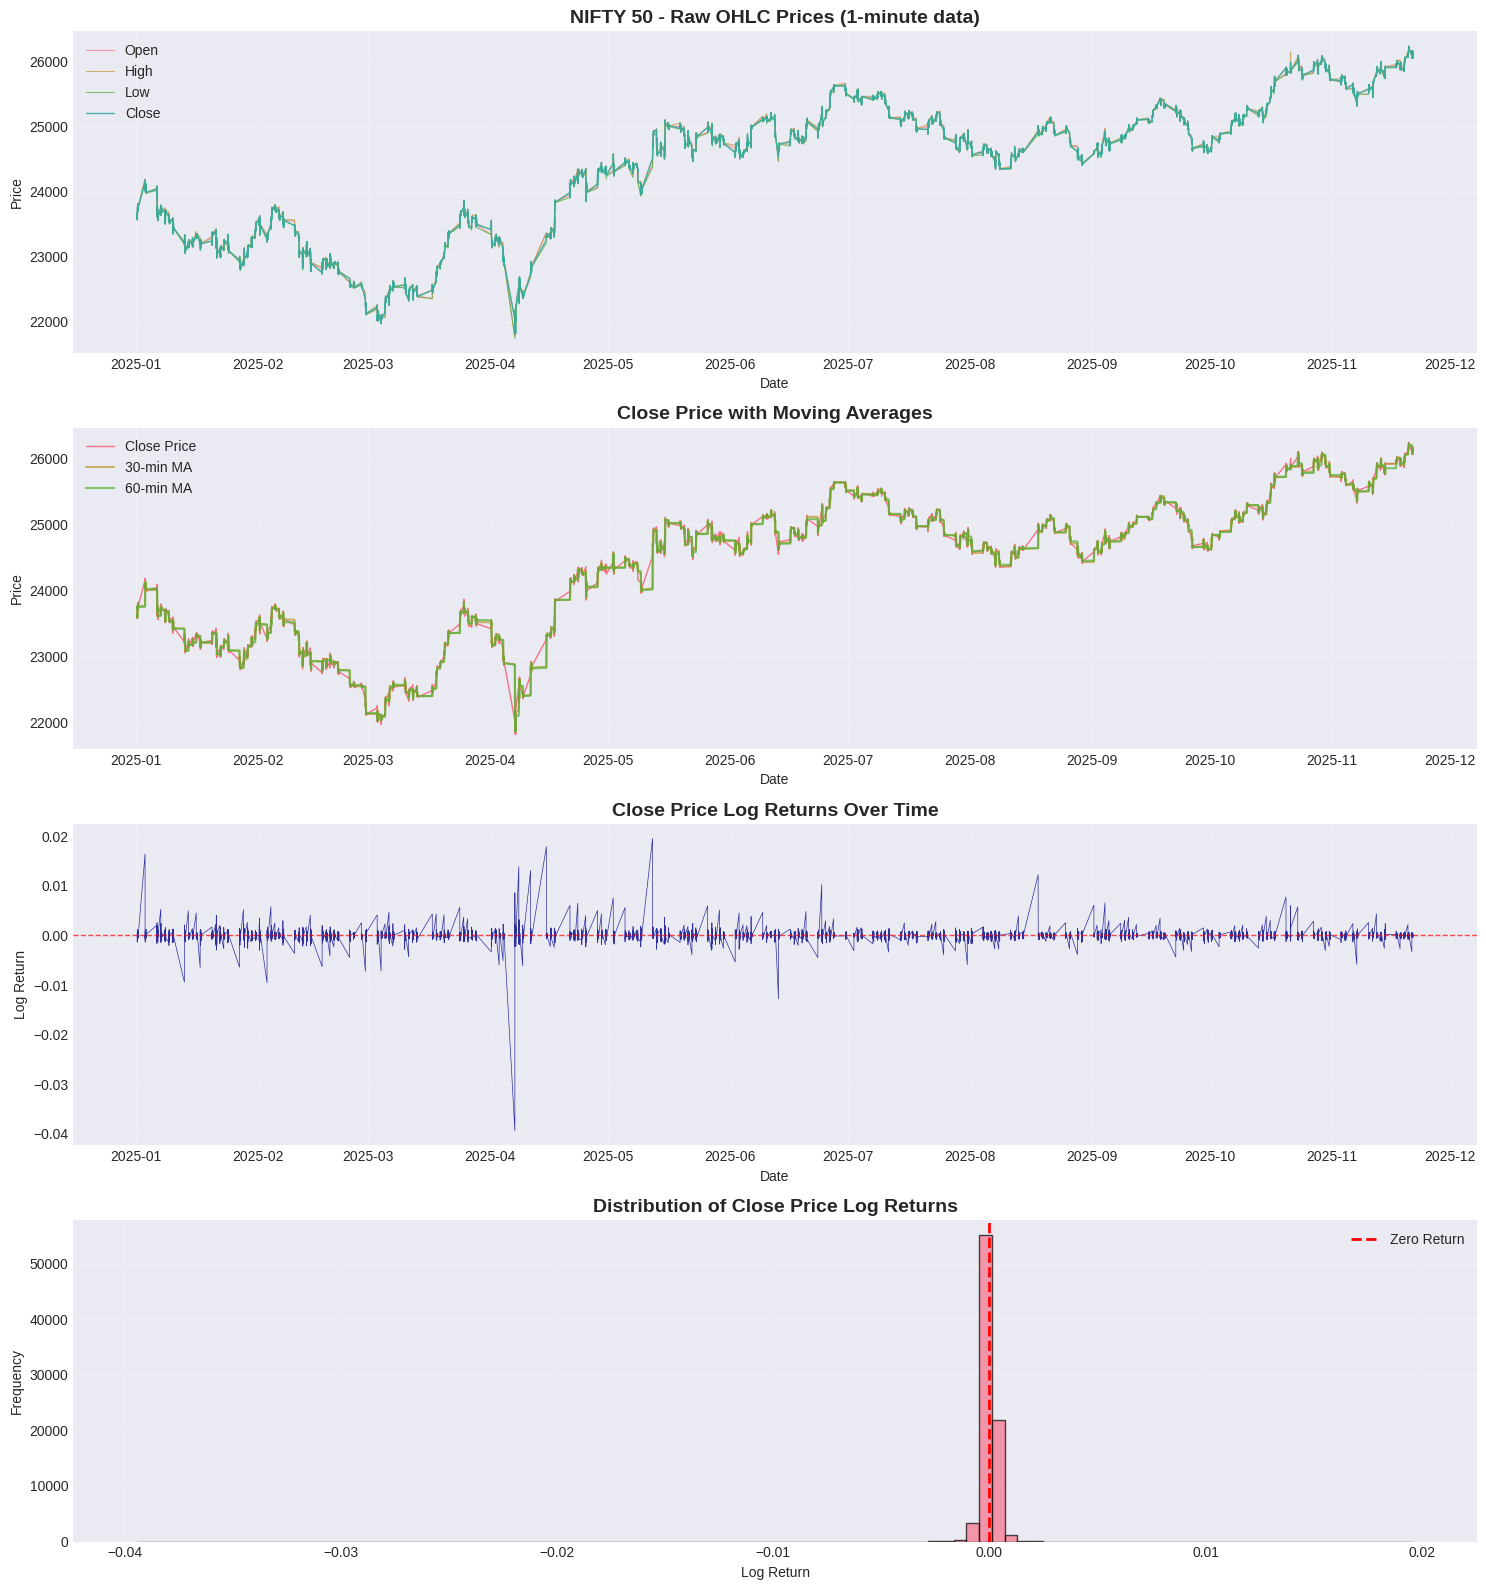

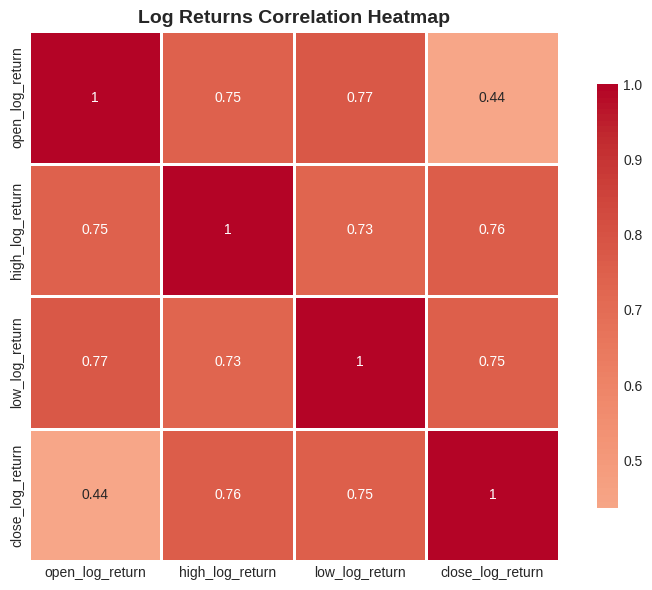

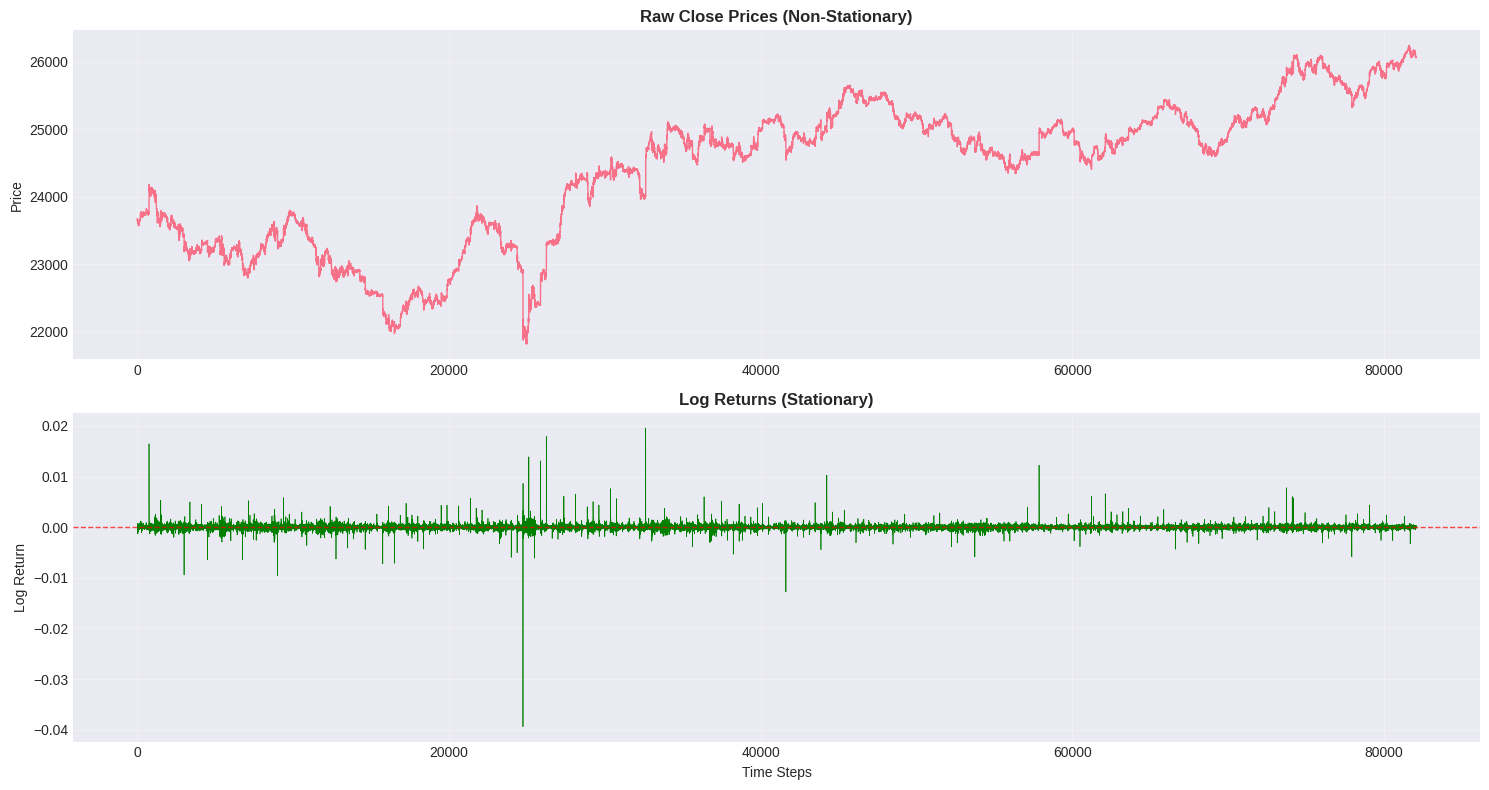


DATA PREPROCESSING

Original log returns shape: (82071, 4)
Scaled log returns shape: (82071, 4)
Scaling range: [0, 1]

Sequences created:
X shape: (82011, 60, 4) (samples, lookback, features)
y shape: (82011,) (samples,)

Data split:
Training set: 57407 samples (70%)
Validation set: 12301 samples (15%)
Test set: 12303 samples (15%)

BUILDING LSTM MODEL

Model Architecture:


Model: "NIFTY50_LSTM_LogReturns"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_Layer_1 (LSTM)             │ (None, 60, 100)        │        42,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Layer_2 (LSTM)             │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,501 (287.11 KB)

 Trainable params: 73,501 (287.11 KB)

 Non-trainable params: 0 (0.00 B)


 Note: Model predicts log returns, which will be converted to prices for evaluation

TRAINING MODEL

Starting training...
Epoch 1/100
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0096 - mae: 0.0555
Epoch 1: val_loss improved from inf to 0.00008, saving model to nifty50_lstm_model.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 0.0096 - mae: 0.0555 - val_loss: 7.7836e-05 - val_mae: 0.0077
Epoch 2/100
895/897 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0464e-04 - mae: 0.0100
Epoch 2: val_loss improved from 0.00008 to 0.00002, saving model to nifty50_lstm_model.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 2.0438e-04 - mae: 0.0100 - val_loss: 2.3481e-05 - val_mae: 0.0028
Epoch 3/100
896/897 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.1644e-05 - mae: 0.0048
Epoch 3: val_loss improved from 0.00002 to 0.00002, saving model to nifty50_lstm_model.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 9.1579e-05 - mae: 0.0048 - val_loss: 2.3111e-05 - val_mae: 0.002

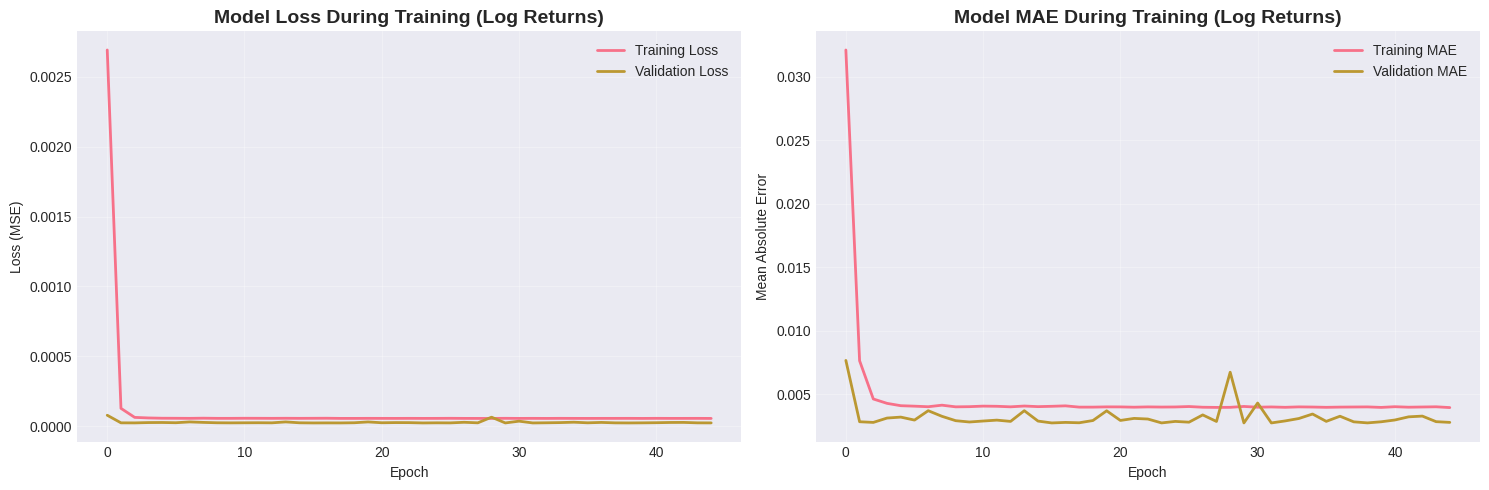


MODEL EVALUATION

 Test Set Performance Metrics (on Absolute Prices):
Root Mean Squared Error (RMSE): 7.3432
Mean Absolute Error (MAE): 4.5707
R² Score: 0.9996
Mean Absolute Percentage Error (MAPE): 0.0178%

 Log Returns Performance:
RMSE on Log Returns: 0.000286

PREDICTION VISUALIZATION


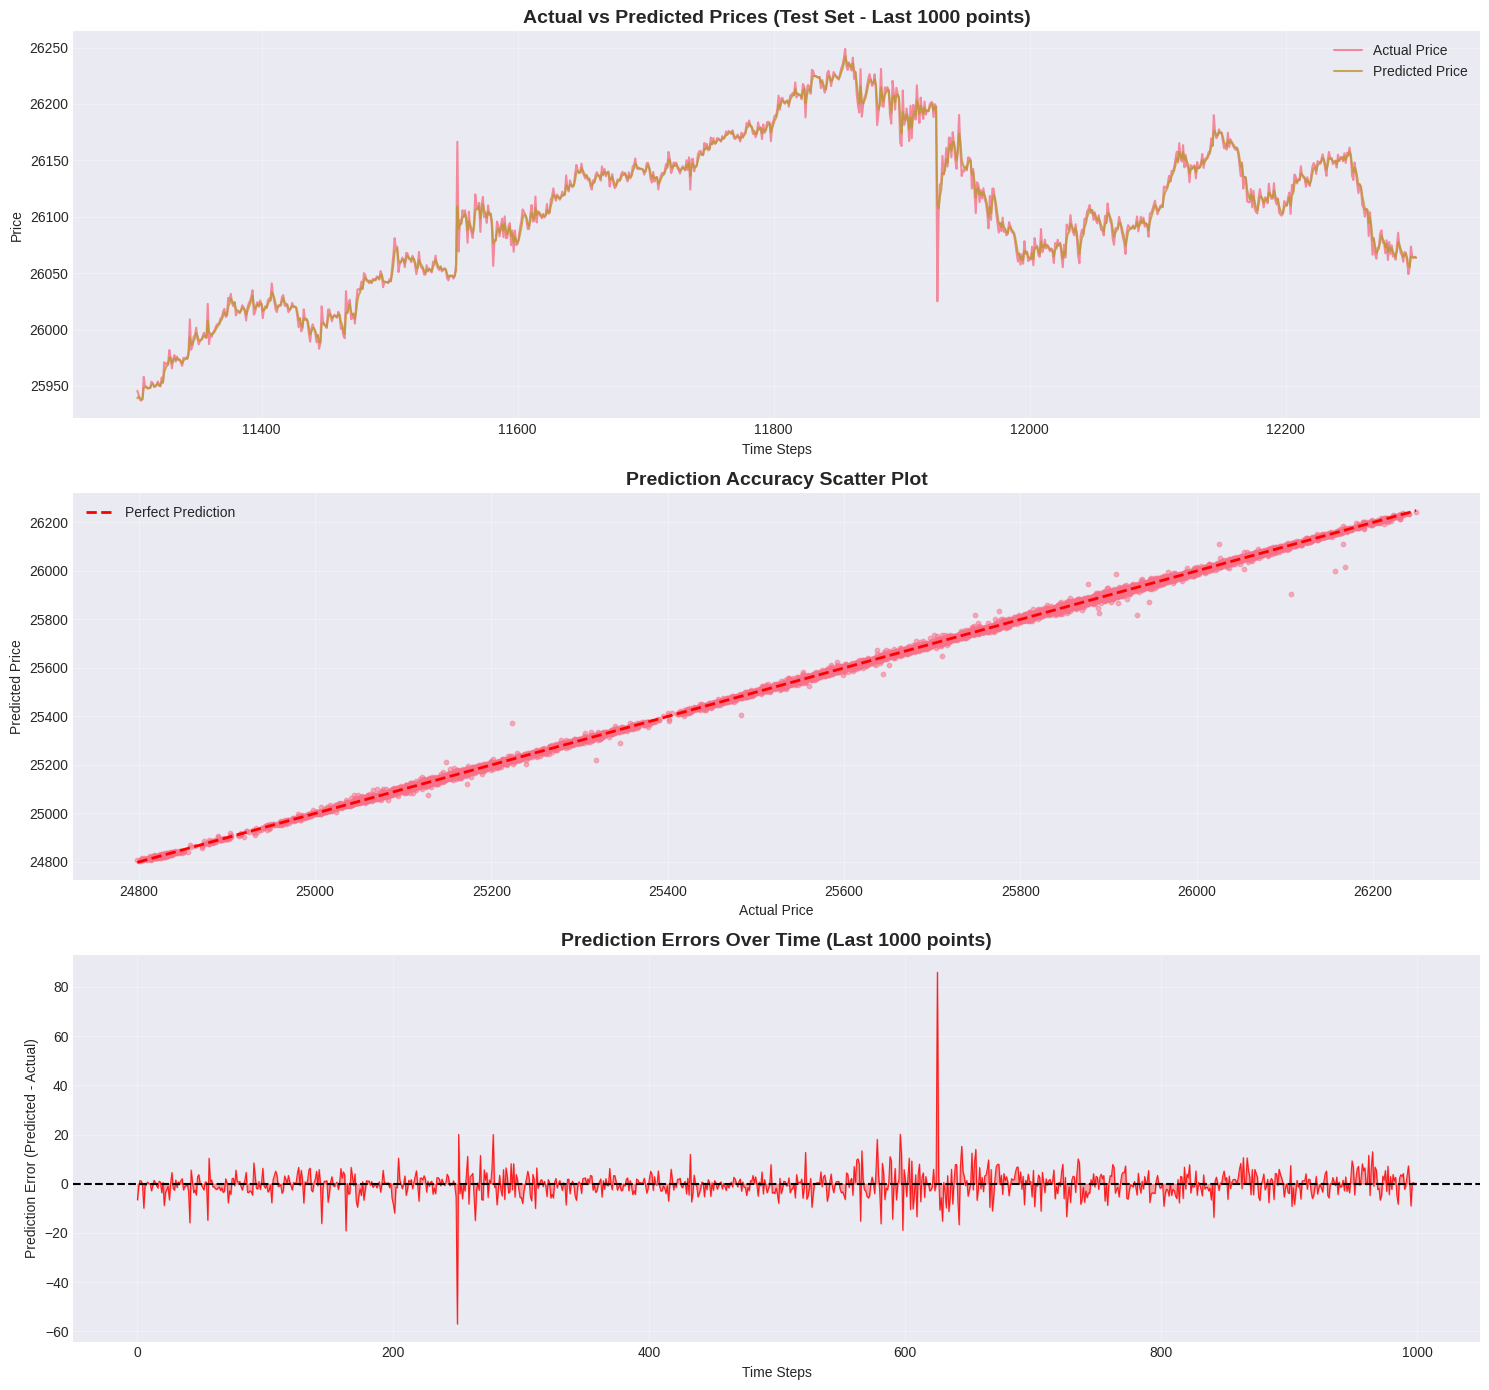

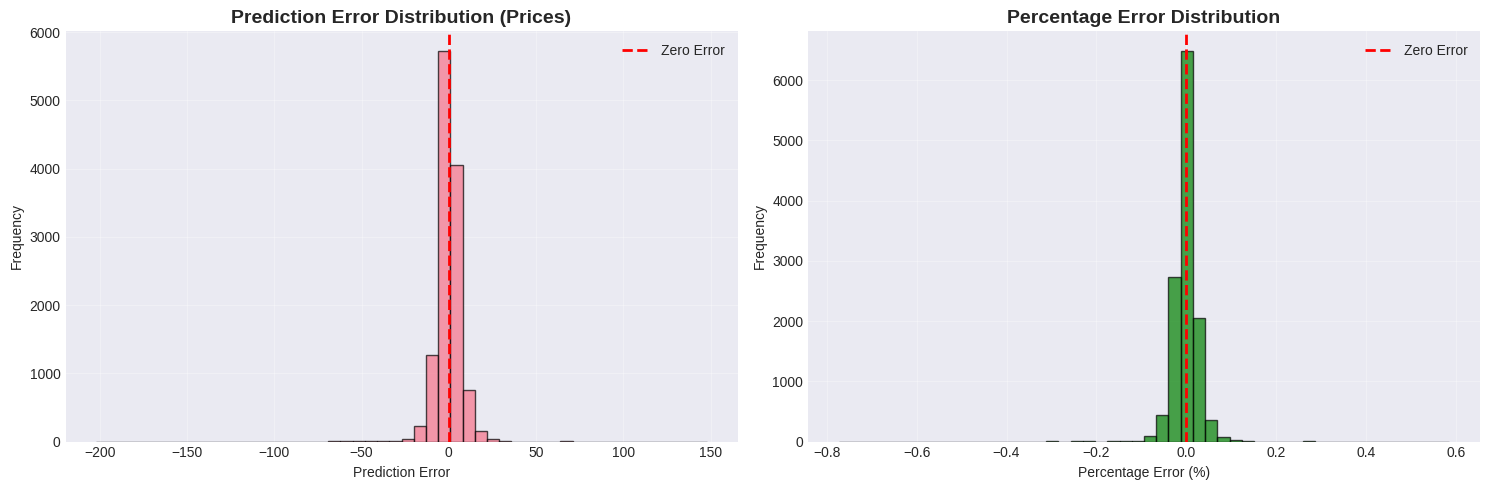


Scaler and metadata saved to: scaler.pkl

PIPELINE COMPLETED SUCCESSFULLY!

 Model saved to: nifty50_lstm_model.keras
Scaler saved to: scaler.pkl


In [14]:
# ============================================================================
# RUN THE PIPELINE
# ============================================================================

if __name__ == "__main__":
    model, scaler, history, df_returns = main()